# Homework 4 - Inference and Representation

## Eric He

## Fall 2019



In [1]:
import numpy as np
import emcee as e
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

# Build an MCMC sampler 

In [15]:
def proposal_gaussian(x, v=1):
    return norm.rvs(x, v)

def accept_reject(x1, x2, log_pdf):
    """
    x1 old
    x2 new
    log_pdf
    """
    log_pdf_x1 = log_pdf(x1)
    log_pdf_x2 = log_pdf(x2)
    if log_pdf_x2 > log_pdf_x1:
        return x2
    else:
        p = uniform.rvs()
        if np.log(p) < log_pdf_x2 - log_pdf_x1:
            return x2
        else:
            return x1
        
def mcmc(init, log_pdf, 
         proposal=proposal_gaussian, 
         niter=10000, burn_in=1000,
         tuned=False, optimal_acceptance=0.4):
    """
    init: np array-like for the parameters
    pdf: function to compute density
    niter: number of iterations
    """
    samples = []
    walk = init
    v = np.array([1., 1.])
    for i in range(niter + burn_in): 
        if tuned & (i < burn_in) & (i % 40 == 0) & (i != 0):
            for j in range(len(v)):
                recent = np.array(samples)[-40:,j]
                acceptance_ratio = len(np.unique(recent)) / 40.
                if acceptance_ratio > optimal_acceptance:
                    v[j] = v[j] * 1.1
                else:
                    v[j] = v[j] / 1.1
#                 print('{}:{}:{}:{}'.format(i, j, acceptance_ratio, v[j]))
        for j in range(len(init)):
            proposed = walk.copy()
            proposed[j] = proposal(walk[j], v[j])
            walk = accept_reject(walk, proposed, log_pdf)
        samples.append(walk)
    return np.array(samples[burn_in:])

def log_gaussian(x):
    return -np.power(x, 2)/2

## Test on Standard Gaussian

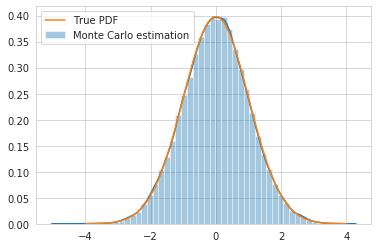

In [3]:
samples = mcmc(init=np.array([0.]), log_pdf=log_gaussian, 
               proposal=proposal_gaussian, niter=100000)
sns.distplot(samples, label='Monte Carlo estimation')
plt.plot(np.linspace(-4, 4), norm.pdf(np.linspace(-4,4)),
         label='True PDF')
plt.legend()

## Test on Standard Bivariate Gaussian with $\mu = [0, 1]$

In [4]:
def log_bivariate_gaussian(x):
    return (-np.power(x - np.array([0, 1]), 2)/2).sum()

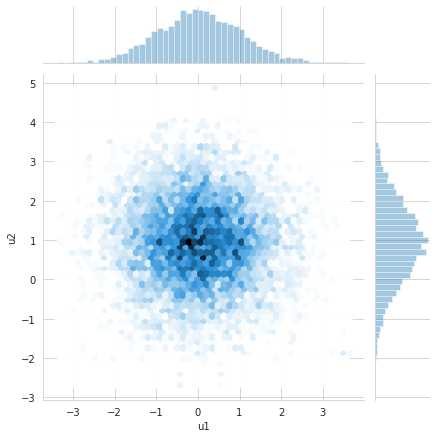

In [5]:
samples = mcmc(init=np.array([0., 0.]), 
               log_pdf=log_bivariate_gaussian, 
               proposal=proposal_gaussian, 
               niter=10000)

sns.jointplot(samples[:,0], 
              samples[:,1], 
              kind='hexbin')\
    .set_axis_labels('u1', 'u2')

# Test on the Rosenbrock density given by:

$$f(\theta_1, \theta_2) = \exp\big(-\dfrac{100(\theta_2 - \theta_1^2)^2 + (1-\theta_1)^2}{20}\big)$$

The logged Rosenbrock density simply removes the exponential term. Maximum density should be attained at $[1, 1]$, however the MCMC implementation here seems unable to display that.

In [6]:
def log_rosenbrock(theta):
    """
    theta is a vector of shape 2
    """
    return -(100 * (theta[1] - theta[0]**2)**2 + (1 - theta[1])**2) / 20

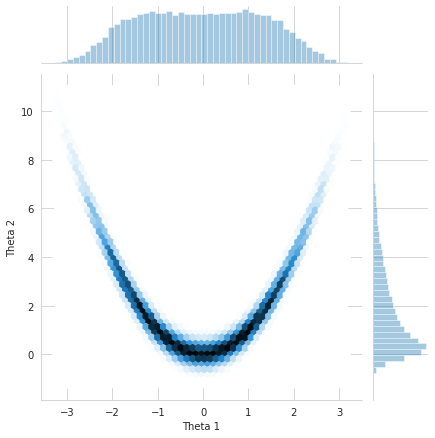

In [7]:
samples = mcmc(np.array([1., 1.]), 
               log_pdf=log_rosenbrock, 
               proposal=proposal_gaussian,
               niter=500000,
               burn_in=20000)

sns.jointplot(samples[:,0], 
              samples[:,1], 
              kind='hexbin')\
    .set_axis_labels('Theta 1', 'Theta 2')

## Default autocorrelation time with untuned proposal

**The empirical autocorrelation function code is taken directly from Dan Foreman-Mackey's notebook.**

In [8]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

Tau estimate on untuned stepping using GW2010 estimation method is 810.3151038168414
Tau estimate on untuned stepping using new estimation method is 884.1658266653059


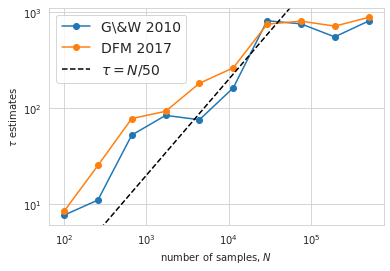

In [9]:
# Compute the estimators for a few different chain lengths
y = samples.T
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="DFM 2017")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
print('Tau estimate on untuned stepping '
       + 'using GW2010 estimation method is {}'.format(gw2010[-1]))
print('Tau estimate on untuned stepping '
      + 'using new estimation method is {}'.format(new[-1]))

# Tune the Gaussian proposal distribution.
We follow the strategy outlined in the homework. We try to optimize for an acceptance fraction of $0.234$ during the burn-in phase by adjusting the covariance matrix of our multivariate Gaussian proposal matrix. 

To make this tractable, the covariance matrix is restricted to be diagonal, so we are essentially tuning each dimension independent of the rest.

To get a good estimate of the acceptance ratio, we adjust once every $40$ iterations per dimension. Depending on whether we are above or below the desired acceptance ratio, we will either halve or double the variance.

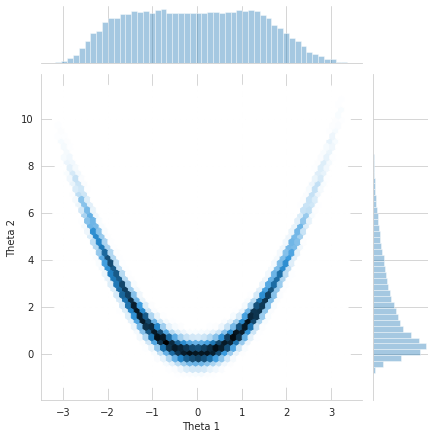

In [19]:
samples = mcmc(np.array([1., 1.]), 
               log_pdf=log_rosenbrock, 
               proposal=proposal_gaussian,
               niter=500000,
               burn_in=20000,
               tuned=True)

sns.jointplot(samples[:,0], 
              samples[:,1], 
              kind='hexbin')\
    .set_axis_labels('Theta 1', 'Theta 2')

# What autocorrelation time do you get?
Using the variance adjustments, I was able to nearly halve the autocorrelation time.

Tau estimate on tuned stepping using GW2010 estimation method is 788.4224488611063
Tau estimate on tuned stepping using new estimation method is 800.8595722060799


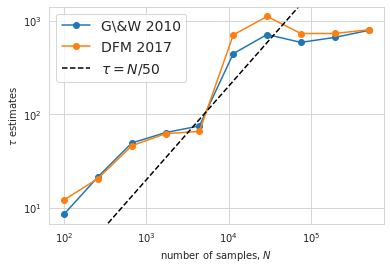

In [18]:
# Compute the estimators for a few different chain lengths
y = samples.T
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="DFM 2017")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
print('Tau estimate on tuned stepping '
       + 'using GW2010 estimation method is {}'.format(gw2010[-1]))
print('Tau estimate on tuned stepping '
      + 'using new estimation method is {}'.format(new[-1]))

# Compare to what `emcee` gets
We run the code to run MCMC sampling with `emcee` below. The sampled distribution looks roughly the same.

In [12]:
nwalkers = 5
sampler = e.EnsembleSampler(nwalkers=nwalkers,
                            ndim=2,
                            log_prob_fn=log_rosenbrock)
# burn in
state = sampler.run_mcmc(np.random.randn(nwalkers, 2),
                 2000)
sampler.reset()

# run
sampler.run_mcmc(state, 100000)

samples = sampler.get_chain(flat=True)

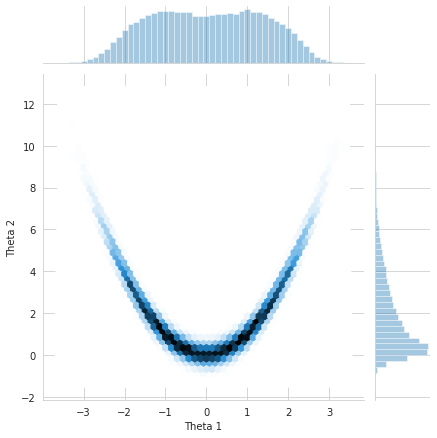

In [13]:
sns.jointplot(samples[:,0], 
              samples[:,1], 
              kind='hexbin')\
    .set_axis_labels('Theta 1', 'Theta 2')

## `emcee` autocorrelation time
`emcee` was able to achieve another halving of the autocorrelation time over my own. 

Though their variance tuning is undoubtedly more sophisticated than this one, what also helps them is that they have an ensemble of walkers rather than a single walker as given by my naive implementation.

Tau estimate on untuned steppingusing GW2010 estimation method is 240.61018847623285
Tau estimate on untuned steppingusing new estimation method is 336.54661836122864


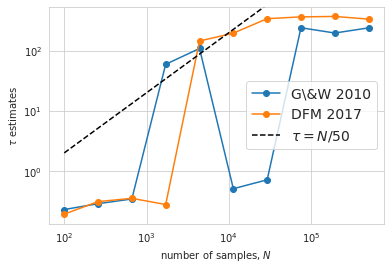

In [14]:
# Compute the estimators for a few different chain lengths
y = samples.T
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="DFM 2017")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
print('Tau estimate on untuned stepping'
       + 'using GW2010 estimation method is {}'.format(gw2010[-1]))
print('Tau estimate on untuned stepping'
      + 'using new estimation method is {}'.format(new[-1]))

In [16]:
np.mean(sampler.acceptance_fraction)

0.42752